In [54]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib
# matplotlib.use('PS')
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from numba import njit
from time import time
# Spline interpolation
from scipy.interpolate import RectBivariateSpline
# Multiprocessing:
from concurrent import futures as fut
from concurrent.futures import ProcessPoolExecutor, as_completed

from ipywidgets import FloatProgress
from IPython.display import display

from mpl_toolkits.mplot3d import Axes3D
import sys
# PATH = '$HOME/git/LCS/notebooks'
sys.path.insert(0, './utility/')
import importlib

In [55]:
factor = 20

Nx = 100 * factor
Ny = 50 * factor

max_notAB = 0.3
h = .0005
n__ = 8
n = n__
fig_s = (10, int(10 * Ny / Nx))

t0 = 0
dt = 0.1
h_ = dt
steps = 200
tmax = dt * steps
spat_res = 0.01
RRD = .5#2e4#DG->.5, NORKYST->2e4?
epsilon = 1 #unused?

AGG_CLUST = 7

In [56]:
strain_path = 'strainlines-AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{}'.format(max_notAB, h, Nx, Ny,n)

import os
from os import path
fig_out_path = 'out/' + strain_path
if not os.path.exists(fig_out_path):
        os.mkdir(fig_out_path)

strain_path = 'strainlines/strainlines-AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{}'.format(max_notAB, h, Nx, Ny,n)

# np.save(strain_path + '/strainlines.npy', np.array([X, y]))
# np.save(strain_path + '/flengths.npy', flengths)
# np.save(strain_path + '/eigvals_mean.npy', eigvals_mean)
# np.save(strain_path + '/lambda2.npy', lambda2)
# np.save(strain_path + '/ABtrue.npy', ABtrue)
# np.save(strain_path + '/nearest_nbs.npy', nearest_nbs)
# np.save(strain_path + '/figure_name.npy', fig_num)

strains = np.load(strain_path + '/strainlines.npy')
X = strains[0,]
y = strains[1,]
flengths = np.load(strain_path + '/flengths.npy')
eigvals_mean = np.load(strain_path + '/eigvals_mean.npy')
lambda2 = np.load(strain_path + '/lambda2.npy')
ABtrue = np.load(strain_path + '/ABtrue.npy')
nearest_nbs = np.load(strain_path + '/nearest_nbs.npy')
fig_num = np.load(strain_path + '/figure_name.npy')
fig_num = str(fig_num)
X0 = np.load('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))

In [57]:
fLCSs = np.rollaxis(strains, 1)
print(fLCSs.shape)

(2912, 2, 2000)


In [58]:
nearest_nbs = np.where(np.isnan(nearest_nbs), 1e2, nearest_nbs)
nearest_nbs_test = np.where(nearest_nbs == 0, 1, nearest_nbs)
nearest_nbs_inv = np.where(nearest_nbs != 0, np.divide(1, nearest_nbs), 1)
mult = .5
NEAREST = np.where(nearest_nbs_inv > 0, 1, 0)

/home/and/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
# fig = plt.figure(figsize=fig_s)
# # for i in range(len(X[:,0])):
# for i in range(strains.shape[1]):
#     plt.plot(X[i,::5], y[i,::5], alpha=0.9, marker='.')

In [60]:
# Euclidean distance.

def euc_dist(pt1,pt2):
    return np.sqrt((pt2[0]-pt1[0])*(pt2[0]-pt1[0])+(pt2[1]-pt1[1])*(pt2[1]-pt1[1]))
def _c(ca,i,j,P,Q):
    if ca[i,j] > -1:
        return ca[i,j]
    elif i == 0 and j == 0:
        ca[i,j] = euc_dist(P[0],Q[0])
    elif i > 0 and j == 0:
        ca[i,j] = max(_c(ca,i-1,0,P,Q),euc_dist(P[i],Q[0]))
    elif i == 0 and j > 0:
        ca[i,j] = max(_c(ca,0,j-1,P,Q),euc_dist(P[0],Q[j]))
    elif i > 0 and j > 0:
        ca[i,j] = max(min(_c(ca,i-1,j,P,Q),_c(ca,i-1,j-1,P,Q),_c(ca,i,j-1,P,Q)),euc_dist(P[i],Q[j]))
    else:
        ca[i,j] = float("inf")
    return ca[i,j]

""" Computes the discrete frechet distance between two polygonal lines
Algorithm: http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
P and Q are arrays of 2-element arrays (points)
"""
def frechetDist(P,Q):
    ca = np.ones((len(P),len(Q)))
    ca = np.multiply(ca,-1)
    return _c(ca,len(P)-1,len(Q)-1,P,Q)

In [61]:
# import pyximport; pyximport.install()
# from frechet import frechet
# import numpy as np 

In [62]:
from scipy.interpolate import interp1d
indices_s = np.linspace(0,1, X.shape[1])

x_spline = interp1d(indices_s, X)

xs = x_spline(np.linspace(0,1, 1200))

y_spline = interp1d(indices_s, y)
ys = y_spline(np.linspace(0,1, 1200))

xys = np.array([xs, ys])


xxyys = xys.swapaxes(0,1)[:,:,::80].copy()
# xxyys = np.reshape(xxyys, (xxyys.shape[0], xxyys.shape[1], 1, xxyys.shape[2]))
print(xxyys.shape)

(2912, 2, 15)


In [63]:
# from MDAnalysis.analysis import psa

num_lines = xxyys.shape[0]
def disc_frech_wrap(PQ,j,i, modulo=1):
    num_lines = PQ.shape[0]
#     print(num_lines)
    lines_left = num_lines - i
    lim = modulo if lines_left > modulo else lines_left
    ret = np.zeros(lim)
    for k in range(lim):
#         ret[k] = min(psa.discrete_frechet(PQ[j,], PQ[k + i,]),psa.discrete_frechet(PQ[j,], PQ[k + i,::-1,]))
        ret[k] = min(frechetDist(PQ[j,], PQ[k + i,]),frechetDist(PQ[j,], PQ[k + i,::-1,]))
#         count += 1
    return ret, j, i
def frech(LINES, mat, n_cores=4, modulo=1):
    PQ = np.moveaxis(LINES, 1, 2).copy()
#     PQ = PQ.reshape(PQ.shape[0], PQ.shape[1], 1, PQ.shape[2]).copy()
    
    futures = []
    progressbar = FloatProgress(min = 0, max = 100)
    display(progressbar)
    with ProcessPoolExecutor(n_cores) as executor:
        for j in range(num_lines):
#             iterr = 0
            for i in range(j + 1, num_lines):
                if (i - j - 1) % modulo == 0:
#                     print(i)
                    futures.append(executor.submit(disc_frech_wrap,
                                                           PQ, j,i, modulo=modulo))
                elif num_lines - i < modulo:
                    futures.append(executor.submit(disc_frech_wrap,
                                                           PQ, j,i, modulo=modulo))
                    break
                    
#                 iterr += 1
            if j % int(num_lines/100)==0:
                    progressbar.value += 1
    
    
    progressbar2 = FloatProgress(min = 0, max = int(len(futures)/100))
    display(progressbar2)
    count = 0
    for p in as_completed(futures):
        count += 1
        if count % int(len(futures) / 100) == 0:progressbar2.value += 1
        try:
            ma, k, r = p.result()
#             ind = 0
#             print(ma.shape)
            lines_left = num_lines - r
            lim = modulo if lines_left > modulo else (num_lines - k - 1)
            for l in range(lim):
                mat[k, r + l] = ma[l].copy()
                mat[r + l, k] = mat[k, r + l]
#                 ind += 1
        except IndexError:
            pass
    print('Finished processing ', count*modulo, ' distances')
    return mat


In [64]:
# from MDAnalysis.analysis import psa


# # futures = []
# psa.discrete_frechet(xxyys[0,], xxyys[1,])

# num = 6
# simsala = np.zeros((num_lines,num_lines))
# start = time()
# simsala = frech(xxyys, simsala, n_cores=12, modulo=1)
# end = time()
# print('Calculated Frechet distances in ', int((end - start)/60), 'min ', (end-start)%60, 'sec')
# sims0 = simsala.copy()

In [65]:
# from MDAnalysis.analysis import psa


# # futures = []
# psa.discrete_frechet(xxyys[0,], xxyys[1,])

# num = 6
# simsala = np.zeros((num_lines,num_lines))
# start = time()
# simsala = frech(xxyys, simsala, n_cores=12, modulo=5)
# end = time()
# print('Calculated Frechet distances in ', int((end - start)/60), 'min ', (end-start)%60, 'sec')

In [66]:
# from MDAnalysis.analysis import psa


# # futures = []
# psa.discrete_frechet(xxyys[0,], xxyys[1,])

# num = 6
# simsala = np.zeros((num_lines,num_lines))
# start = time()
# simsala = frech(xxyys, simsala, n_cores=12, modulo=10)
# end = time()
# print('Calculated Frechet distances in ', int((end - start)/60), 'min ', (end-start)%60, 'sec')

In [67]:
import multiprocessing

cpus = multiprocessing.cpu_count()
cpus

12

In [68]:
# from MDAnalysis.analysis import psa

import multiprocessing

cpus = multiprocessing.cpu_count()
run_n_cpus = cpus - 3*(1 if cpus > 2 and cpus < 16 else 0) 
#limit number of cores when running on my desktop. (don want no heat) 
print('Spinning up', run_n_cpus, 'processes at a time')
# futures = []
# psa.discrete_frechet(xxyys[0,], xxyys[1,])

num = 6
simsala = np.zeros((num_lines,num_lines))
start = time()
simsala = frech(xxyys, simsala, n_cores=run_n_cpus, modulo=5)
end = time()
print('Calculated Frechet distances in ', int((end - start)/60), 'min ', (end-start)%60, 'sec')

Spinning up 9 processes at a time


FloatProgress(value=0.0)

FloatProgress(value=0.0, max=8500.0)

Finished processing  4250070  distances
Calculated Frechet distances in  24 min  33.03449320793152 sec


In [69]:
# from MDAnalysis.analysis import psa


# # futures = []
# psa.discrete_frechet(xxyys[0,], xxyys[1,])

# num = 6
# simsala = np.zeros((num_lines,num_lines))
# start = time()
# simsala = frech(xxyys, simsala, n_cores=12, modulo=40)
# end = time()
# print('Calculated Frechet distances in ', int((end - start)/60), 'min ', (end-start)%60, 'sec')

In [70]:
simsala

array([[0.        , 0.00666454, 0.01341724, ..., 1.07987038, 1.07948349,
        1.07909758],
       [0.00666454, 0.        , 0.00675405, ..., 1.07955174, 1.07916454,
        1.07877833],
       [0.01341724, 0.00675405, 0.        , ..., 1.0792303 , 1.07884278,
        1.07845626],
       ...,
       [1.07987038, 1.07955174, 1.0792303 , ..., 0.        , 0.00567594,
        0.01156214],
       [1.07948349, 1.07916454, 1.07884278, ..., 0.00567594, 0.        ,
        0.00588633],
       [1.07909758, 1.07877833, 1.07845626, ..., 0.01156214, 0.00588633,
        0.        ]])

In [71]:
# np.where(simsala - sims0 != 0)

In [89]:
nearest_nbs2 = 3*(simsala/RRD) 
nearest_nbs_inv2 = np.where(simsala > 1e-2, nearest_nbs2, -1)
nearest_nbs_inv2 = np.where(nearest_nbs_inv2 > 0, nearest_nbs_inv2, np.max(nearest_nbs_inv2))

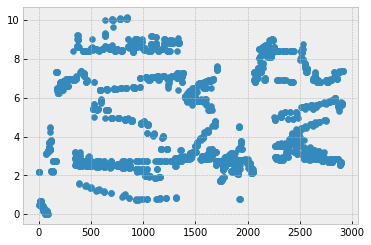

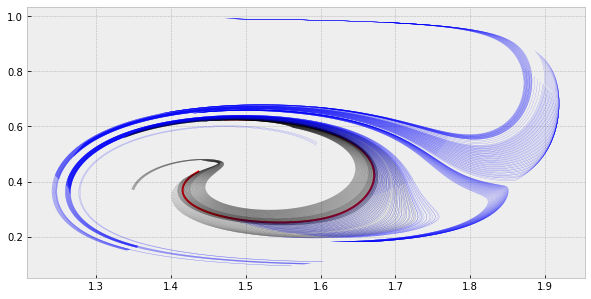

In [94]:
# xxyys = np.moveaxis(xxyys, 2, 1)
num =64
plt.scatter(np.linspace(0,xxyys.shape[0], xxyys.shape[0]), nearest_nbs2[num,:])
plt.savefig(fig_out_path + '/frechet_sim_values.png')
fig = plt.figure(figsize=fig_s)
plt.plot(xys[0, num,:],xys[1, num,:], 'r', lw=2)
for i in range(xxyys.shape[0]):
    if nearest_nbs2[num, i] < 1.5 and i != num: plt.plot(xys[0,i,:],xys[1,i,:], 'k', lw=0.10)
    elif nearest_nbs2[num, i] < 2.5: plt.plot(xys[0,i,:],xys[1,i,:], 'b', lw=0.1)
#     elif nearest_nbs2[num, i] < 2.0: plt.plot(xys[0,i,:],xys[1,i,:], 'g', lw=0.1)
#     elif nearest_nbs2[num, i] < 3.5: plt.plot(xxyys[i,0,:],xxyys[i,1,:], 'c', lw=0.1)

plt.savefig(fig_out_path + '/frechet_sim_lines.png')


In [95]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn import datasets, cluster
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import chi2_kernel, laplacian_kernel, rbf_kernel

n_comps = 10
pca = PCA(n_components=n_comps)
# kpca0 = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=n_comps)
kpca1 = KernelPCA(kernel="poly", n_components=n_comps, degree=5)
# kpca2 = KernelPCA(kernel="linear", fit_inverse_transform=True, n_components=n_comps)
# kpca3 = KernelPCA(kernel="poly", fit_inverse_transform=True, n_components=n_comps*10)
# X_kpca0 = kpca0.fit_transform(X, y)
# X_kpca0 = kpca0.fit_transform(X_kpca0, nearest_nbs)

X_kpca1 = kpca1.fit_transform(X, y)
# X_kpca1 = kpca1.fit_transform(X_kpca1, nearest_nbs)

# X_kpca2 = kpca2.fit_transform(X, y)
# X_kpca2 = kpca2.fit_transform(X_kpca2, nearest_nbs_inv)

# X_kpca3 = kpca3.fit_transform(X, y)
#X_kpca3 = kpca3.fit_transform(X_kpca3, nearest_nbs_inv)
#NEIGH_feats = kpca0.fit_transform(nearest_nbs)
print('done')


done


(2912, 10)
(2912, 10)


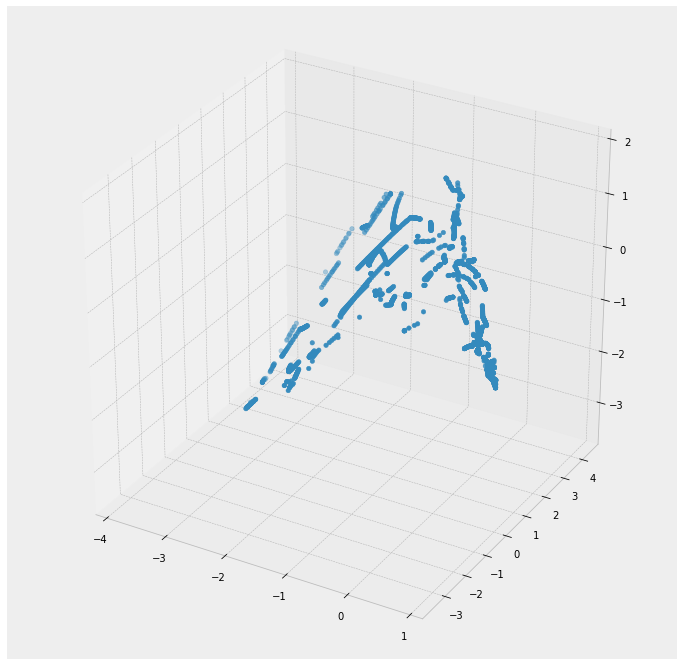

In [96]:
X_new = X_kpca1[:,0::]

from sklearn.preprocessing import StandardScaler, RobustScaler

X_new = StandardScaler().fit_transform(X_new)
# for i in range(X_new.shape[1]):
#     X_new[:,i] = X_new[:,i] / np.std(X_new[:,i])
#X_kpca = kpca1.fit_transform(X_kpca, nearest_nbs)
print(X_new.shape)
# #fig = plt.figure(figsize=(16,8))
# plt.scatter(X_kpca[:,0], X_kpca[:,1])
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs=X_new[:,0], ys=X_new[:,1], zs=X_new[:,2], zdir='z')
# ax.set_xlim3d(-.001, .001)
# ax.set_ylim3d(-.001, .001)
# ax.set_zlim3d(-.001, .001)

X_new = X_new#[:, ::1]
#print(X_new[:,0])
# fig = plt.figure(figsize=(16,8))
#plt.scatter(X_new[:,0], X_new[:,1], color = 'k')
print(X_new.shape)


Strainlines represented by points in 10 dimensional space using K-PCA.
#             Projected down onto 3 dimensions.


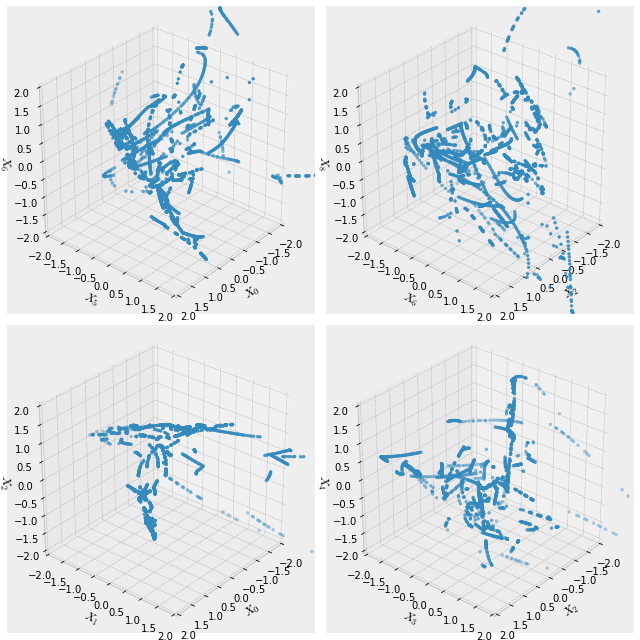

In [97]:

fig = plt.figure(figsize=(9,9))
print('Strainlines represented by points in 10 dimensional space using K-PCA.\n\
#             Projected down onto 3 dimensions.')
s = 8
ax = fig.add_subplot(2,2,3, projection='3d')
ax.scatter(xs=X_new[:,0], ys=X_new[:,1], zs=X_new[:,2], zdir='z', s=s)
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.view_init(30, 40)
plt.tight_layout()
ax = fig.add_subplot(2,2,4, projection='3d')
ax.scatter(xs=X_new[:,2], ys=X_new[:,3], zs=X_new[:,4], zdir='z', s=s)
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)
ax.view_init(30, 40)
ax.set_xlabel('$X_2$')
ax.set_ylabel('$X_3$')
ax.set_zlabel('$X_4$')
plt.tight_layout()
ax = fig.add_subplot(2,2,1, projection='3d')
ax.scatter(xs=X_new[:,0], ys=X_new[:,5], zs=X_new[:,6], zdir='z', s=s)
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_5$')
ax.set_zlabel('$X_6$')
ax.view_init(30, 40)
plt.tight_layout()
ax = fig.add_subplot(2,2,2, projection='3d')
ax.scatter(xs=X_new[:,2], ys=X_new[:,6], zs=X_new[:,8], zdir='z', s=s)
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)
ax.set_xlabel('$X_2$')
ax.set_ylabel('$X_6$')
ax.set_zlabel('$X_8$')
ax.view_init(30, 40)
plt.tight_layout()
plt.savefig(fig_out_path + '/kpca_projection' + fig_num +'.png')

In [98]:
def find_max_lcss(fLCSs, n_clusters_, labels, flen, flambs):
    num_clust = n_clusters_

    #flengths
    #eigvals_mean

    #array for holding the selected LCSs
    chosen_LCS = []
    #find which lines belong to a cluster
    
    
    ####need to fix here for second run -- cant multiply by step and expect correct indices. mapping?
    len_min = .01
    for k in range(num_clust):
        #print("cluster %d  " %k)
        my_members = labels == k
        if(my_members.size == 1): continue
        indices = np.where(my_members)
        local_lines = []
        if (len(indices[0]) < 3 or indices[0] is None):
            continue
        for i in range(len(indices)):

            local_lines.append(indices[0][i])
    
        #local_lines = indices

        ind = 0
        identity = -1
        maxi_lamb = 0
        maxi_len = 0
        leng = len(local_lines)
        #print(local_lines)
        for i in set(local_lines):
            if flengths[i] > len_min:
                if eigvals_mean[i] > maxi_lamb:
                #if flengths[i] > flengths[identity]:# and (np.abs(eigvals_mean[i] - maxi_lamb) < 1e-1 or eigvals_mean[i] > maxi_lamb):
                    identity = i
                    maxi_lamb = eigvals_mean[i]
                    maxi_len = flengths[i] 
                else:
                    if eigvals_mean[i] == maxi_lamb and flengths[i] > maxi_len:
                        identity = i
                        maxi_len = flengths[i]
                        maxi_lamb = eigvals_mean[i]
        if identity not in chosen_LCS and identity != -1: chosen_LCS.append(identity)
        #print("identity: %d \n" % identity)

    print(chosen_LCS)

    return chosen_LCS

In [99]:
def cherryPicker(chosen_LCS, flambs, nearest_nbs, epsilon, mult=1):
    count = len(chosen_LCS)
    num_lines = len(nearest_nbs[0,:])
    new_chosen = []
    for i in set(chosen_LCS):
        #trying mean rather than median
        threshold = 1*mult#*np.mean(nearest_nbs[i,np.where(nearest_nbs[i,:] > 0 )])
        similars = []
        similars.append(i)
        for j in set(chosen_LCS):
            if i == j: continue
            if min(nearest_nbs[i,j], nearest_nbs[j,i]) < threshold:
                similars.append(j)
        line = i
        for k in range(len(similars)):
            if flambs[i] < flambs[similars[k]]:
                line = similars[k]
        #try to weed out the weak
        for o in set(similars):
            if o in new_chosen:# and np.abs(flengths[o] - flengths[line]) > 0.7*max(flengths[o], flengths[line]):
                new_chosen.remove(o)
        
        if line not in new_chosen:
            new_chosen.append(line)
    return new_chosen

4.0
4.0
Estimated number of clusters: 15
[]


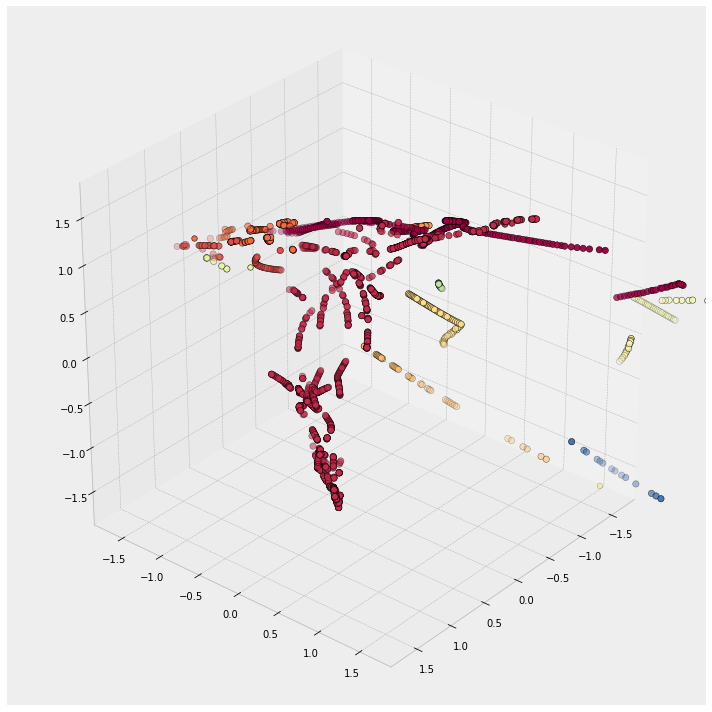

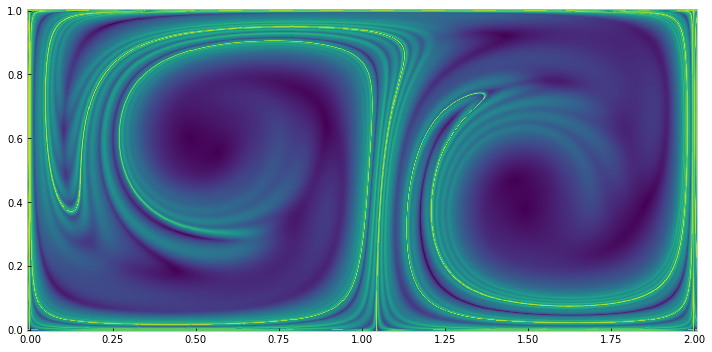

In [100]:
from sklearn.cluster import DBSCAN
X_ = X_new

# extra = 0 if  X.shape[1] % 4 == 0 else 1
# X_ = np.empty((X.shape[0], 2, int(X.shape[1]/4) + extra))

# X_[:,0,:] = X[:,::4]
# X_[:,1,:] = y[:,::4]

epsil0 = 4. #(np.amax(X_) - np.amin(X_)) / 2
print(epsil0)
epsil = epsil0
_clust = 40
samps = 3
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps).fit(X_)#fit(X_.reshape(X_.shape[0], 2*X_.shape[2]))
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 40
    if epsil <= epsil0 /  2.5: 
        _clust -= 3
        epsil = epsil0
        if _clust < 5:
            print('couldnt find shit')
            break
        
print(epsil)        
import time as tid

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=40, edgecolor='k')

    xy = X_[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=30, edgecolor='k')
print('Estimated number of clusters: %d' % n_clusters_)
ax.set_xlim3d(-1.8, 1.8)
ax.set_ylim3d(-1.8, 1.8)
ax.set_zlim3d(-1.8, 1.8)
ax.view_init(30, 40)
plt.tight_layout()

plt.savefig(fig_out_path + '/Kpca_DB_clusters' + fig_num +'.png')
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.3)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i,0,:], fLCSs[i,1,:], c = 'k', lw = 2 )
plt.tight_layout()
plt.savefig(fig_out_path + '/Kpca_DB_clusters_full' + fig_num +'.png')

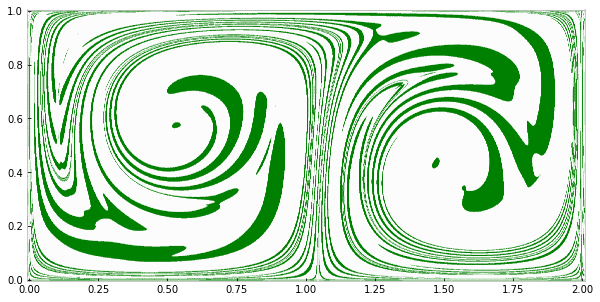

In [101]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=2.)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/Kpca_DB_' + fig_num +'.png')

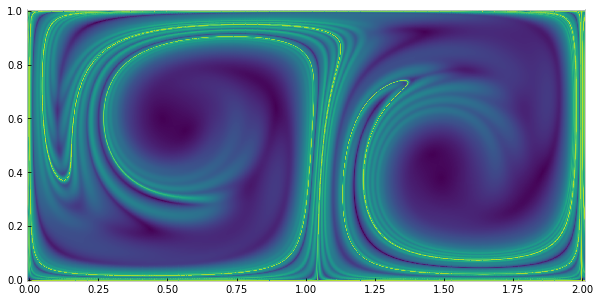

In [102]:
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/Kpca_DB_' + fig_num +'.png')

# ADVECTION_LINES = new_chosen

Estimated number of clusters: 15


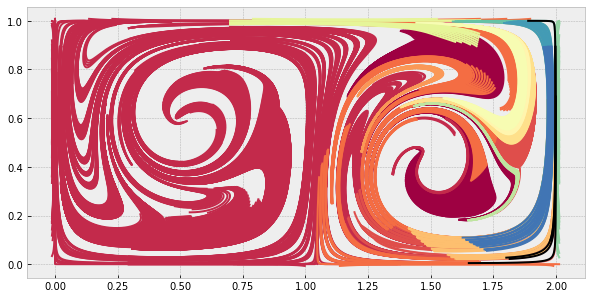

In [103]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):

        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/Kpca_DB_clusters_cols' + fig_num +'.png')

Estimated number of clusters: 72
[]


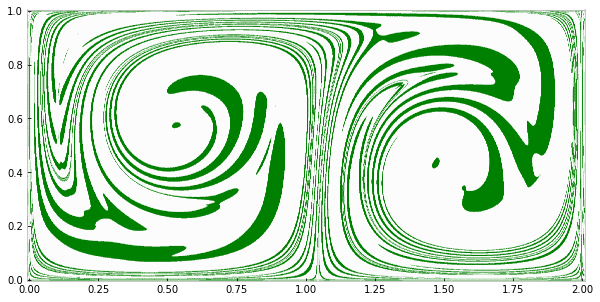

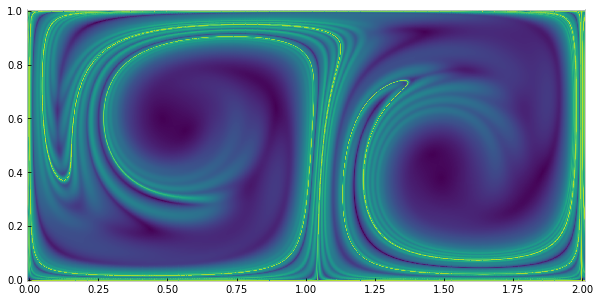

In [104]:
from sklearn.cluster import AffinityPropagation
scaler = StandardScaler()
X_ = scaler.fit_transform(X_new)
# X_ = scaler.fit_transform(sims_)
scaled_eigs = scaler.fit_transform(eigvals_mean[:,0,])
af = AffinityPropagation(damping=0.8, preference=-7e1*np.exp(-scaled_eigs)).fit(X_)
# af = AffinityPropagation(damping=0.7, preference=-9.5e3*np.exp(scaled_eigs)).fit(X_)
# af = AffinityPropagation(damping=0.7, preference=-4.5e3*nearest_nbs2).fit(X_)
# af = AffinityPropagation(damping=0.75, preference=-2.5e3 * eigvals_mean[:,0,0]/eigvals_mean[:,0,0].mean()).fit(X_)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


print('Estimated number of clusters: %d' % n_clusters_)


chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.9)#4e-4
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/kpca_AFF_clusters' + fig_num +'.png')
ADVECTION_LINES = new_chosen

Estimated number of clusters: 72


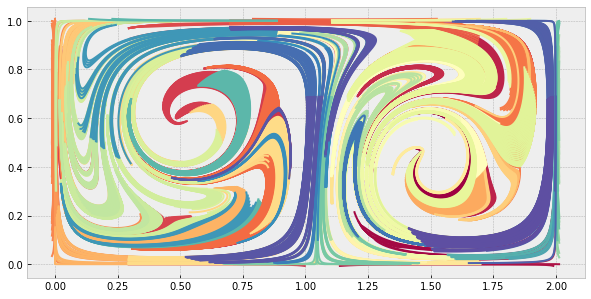

In [105]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/Kpca_AFF_clusters_cols' + fig_num +'.png')

In [106]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA


kpca0 = KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=25, n_jobs=-1, gamma=1/12 )

# pca = PCA(n_components=3)
X__ = kpca0.fit_transform(X,y)
# print(np.sum(pca.explained_variance_ratio_))
# X__ = kpca0.fit_transform(X__, nearest_nbs)
# print(np.sum(pca.explained_variance_ratio_))
# tsne = TSNE(n_components=3, init='pca', random_state=0)
# t0 = time()
# # X_tsne = tsne.fit_transform(X, y)
# X_tsne = tsne.fit_transform(X__)

# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
# fig = plt.figure(figsize=fig_s)

# ax = fig.add_subplot(111, projection='3d')

# # plt.scatter(X_tsne[:,0], X_tsne[:,1])
# ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')
# plt.savefig(fig_out_path + '/tsne_xy_ppl30_' + fig_num +'.png')

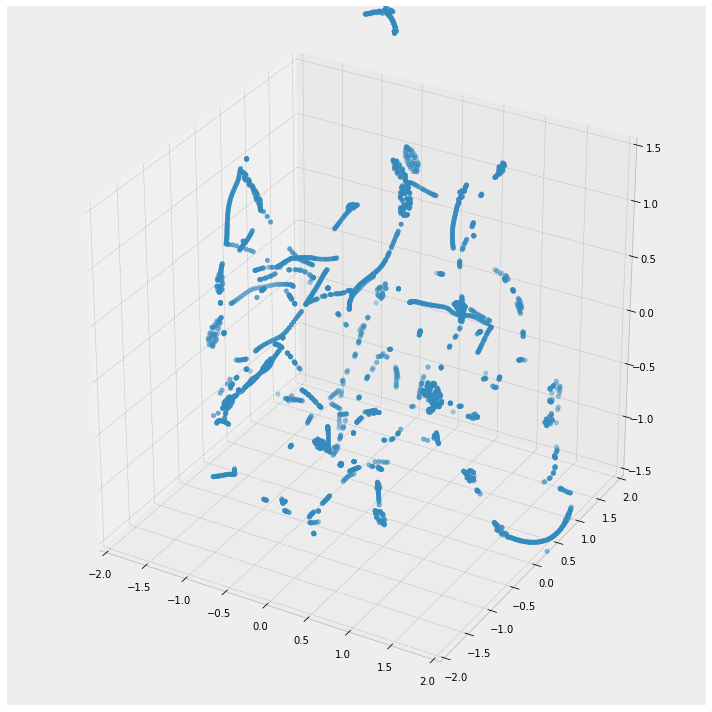

In [107]:
tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=1500, perplexity=50)
X_tsne = tsne.fit_transform(X__)
for i in range(X_tsne.shape[1]):
    X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# plt.scatter(X_tsne[:,0], X_tsne[:,1])
ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(-1.5, 1.5)
plt.tight_layout()
plt.savefig(fig_out_path + '/tsne_xy_ppl50_' + fig_num +'.png')

In [108]:
X_new = X_tsne

Estimated number of clusters: 338
[]


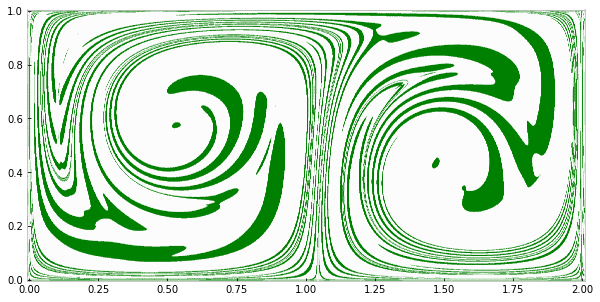

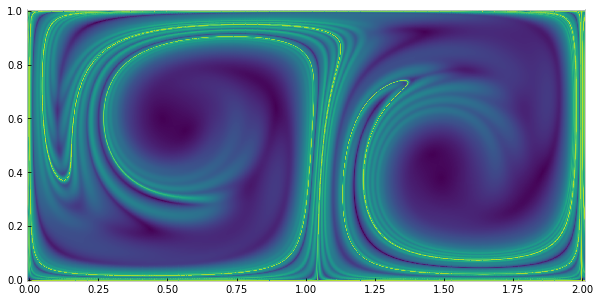

In [109]:
from sklearn.cluster import AffinityPropagation
X_ = X_new
af = AffinityPropagation(damping=0.55, preference=-5e0*np.exp(-scaled_eigs)).fit(X_)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
try:
    n_clusters_ = len(cluster_centers_indices)
except:
    n_clusters_ = 0

print('Estimated number of clusters: %d' % n_clusters_)


chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=2.0)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/TSNE_Aff_' + fig_num +'.png')


Estimated number of clusters: 338


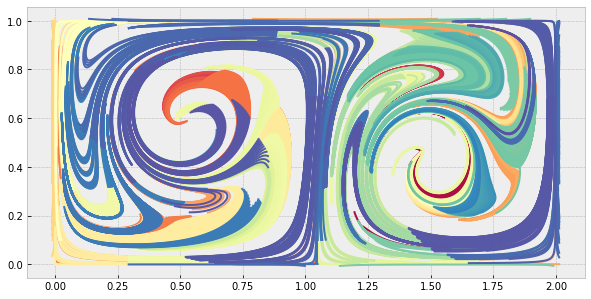

In [110]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/TSNE_AFF_cols' + fig_num +'.png')

Estimated number of clusters: 338


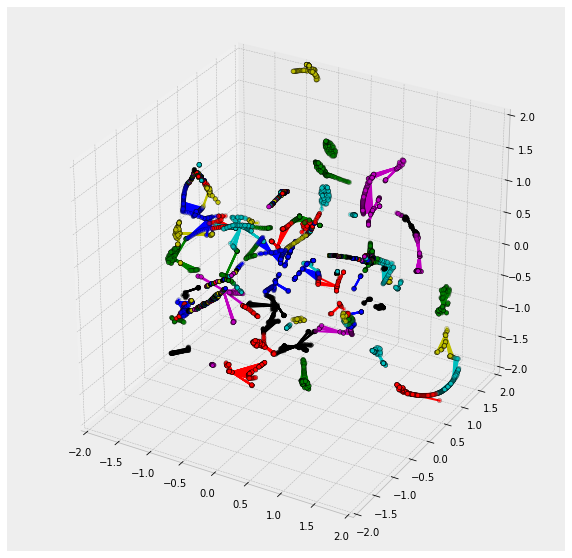

In [111]:
from itertools import cycle
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_[cluster_centers_indices[k]]
    ax.scatter(X_[class_members, 0], X_[class_members, 1], X_[class_members, 2], c=col, edgecolor='k')
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], 'o', c=col, s=14, edgecolor='k')
    for x in X_[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], [cluster_center[2], x[2]], col)
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(-2.0, 2.0)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/TSNE_Aff__clusters' + fig_num +'.png')

Estimated number of clusters: 24
[]
0.9
0.9


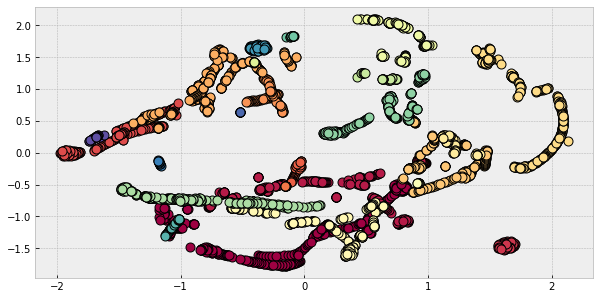

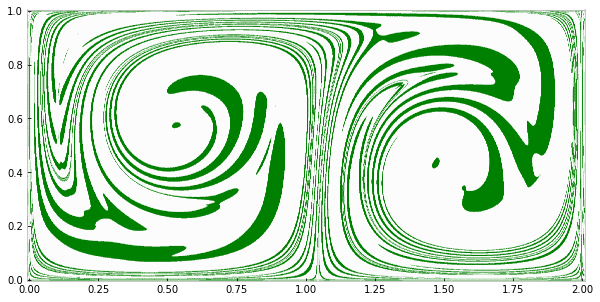

In [136]:
from sklearn.cluster import DBSCAN
X_ = X_new



epsil0 = .9
epsil = epsil0
_clust = 40
samps = 5
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps, p=3, metric='minkowski', n_jobs=-1).fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 60
    if epsil <= epsil0 / 4:
        _clust -= 3
        epsil = epsil0
        if _clust < 5:
            print('couldnt find shit')
            break
        
import time as tid
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.010): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)

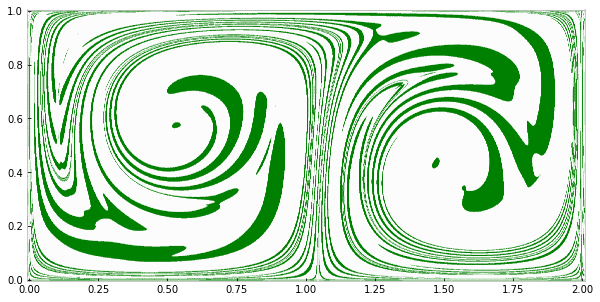

In [113]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.85)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
        #print(i)
    



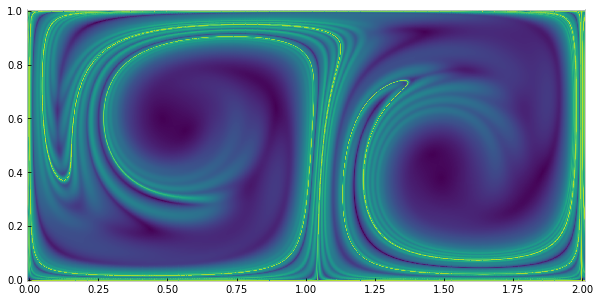

In [114]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.85)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/TSNE_DB_' + fig_num +'.png')

Estimated number of clusters: 24


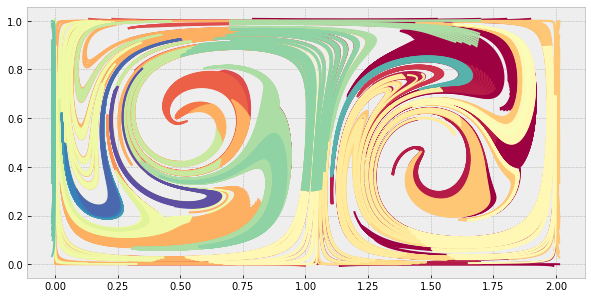

In [115]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/TSNE_DB_cols' + fig_num +'.png')

Estimated number of clusters: 53
Estimated number of clusters: 53
[]
0.6
0.1799999999999996
50


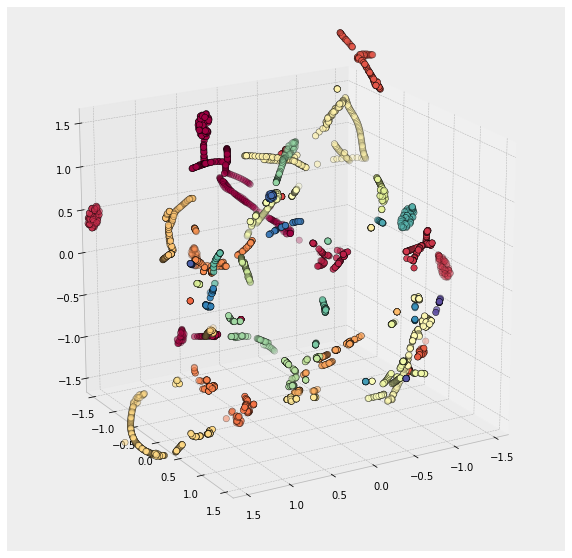

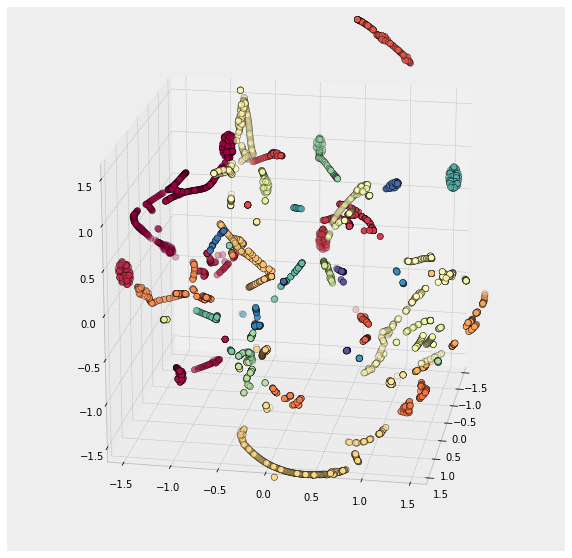

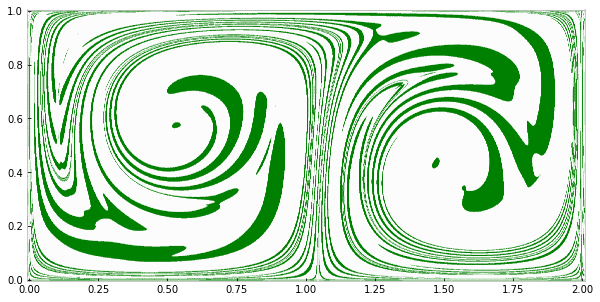

In [116]:
from sklearn.cluster import DBSCAN
X_ = X_new
# X_ = X


epsil0 = .6
epsil = epsil0
_clust = 50
samps =3
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps, n_jobs=-1).fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 40
    if epsil <= epsil0 / 4: 
        epsil = epsil0
        _clust -= 5
        if _clust < 5:
            print('couldnt find shit')
            break
        
import time as tid


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=40, edgecolor='k')

    xy = X_[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=30, edgecolor='k')
print('Estimated number of clusters: %d' % n_clusters_)
ax.set_xlim3d(-1.6, 1.6)
ax.set_ylim3d(-1.6, 1.6)
ax.set_zlim3d(-1.6, 1.6)
ax.view_init(20, 60)
plt.savefig(fig_out_path + '/TSNE_DB_ppl60_clusters1_2_' + fig_num +'.png')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=40, edgecolor='k')

    xy = X_[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=30, edgecolor='k')
print('Estimated number of clusters: %d' % n_clusters_)
ax.set_xlim3d(-1.6, 1.6)
ax.set_ylim3d(-1.6, 1.6)
ax.set_zlim3d(-1.6, 1.6)
ax.view_init(20, 10)
plt.savefig(fig_out_path + '/TSNE_DB_ppl60_clusters0_2_' + fig_num +'.png')

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)
print(_clust)

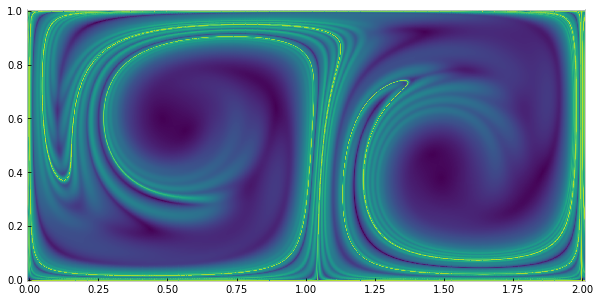

In [117]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.8)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
        print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/TSNE_DB_ppl602_' + fig_num +'.png')
ADVECTION_LINES = new_chosen

Estimated number of clusters: 53


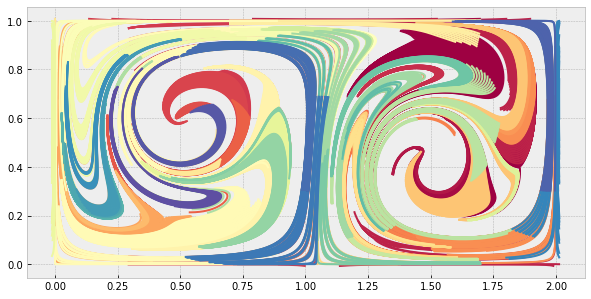

In [118]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/TSNE_DB_ppl60_clusters2_cols' + fig_num +'.png')

# Clustering directly on sim matrix


In [119]:
nearest_nbs2.min()


0.0

In [120]:
# ?np.ufunc

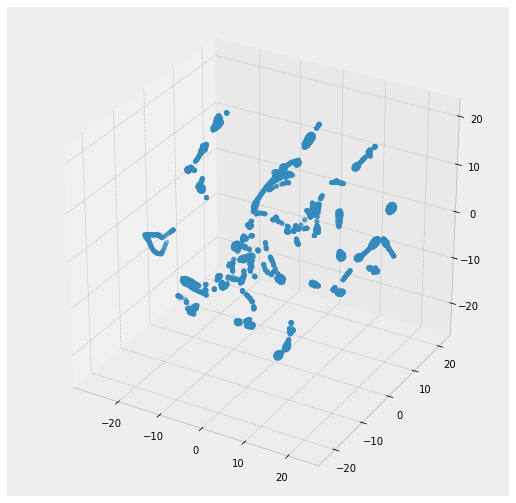

In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
kpca0 = KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=25, n_jobs=-1, gamma=1/13)
# pca = PCA(n_components=30, whiten=True)
# X__ = kpca0.fit_transform(X,y)
# print(np.sum(pca.explained_variance_ratio_))
X__ = kpca0.fit_transform(nearest_nbs2)
X__ = StandardScaler().fit_transform(X__)
tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=1500, perplexity=60, method='exact')#, method='exact')
X_tsne = tsne.fit_transform(X__)
# for i in range(X_tsne.shape[1]):
#     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
fig = plt.figure(figsize=(9,9))

ax = fig.add_subplot(111, projection='3d')

# plt.scatter(X_tsne[:,0], X_tsne[:,1])
ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')
plt.savefig(fig_out_path + '/tsne_neighbor_' + fig_num +'.png')

Estimated number of clusters: 18
Estimated number of clusters: 18
[]
1.0
1.0
16


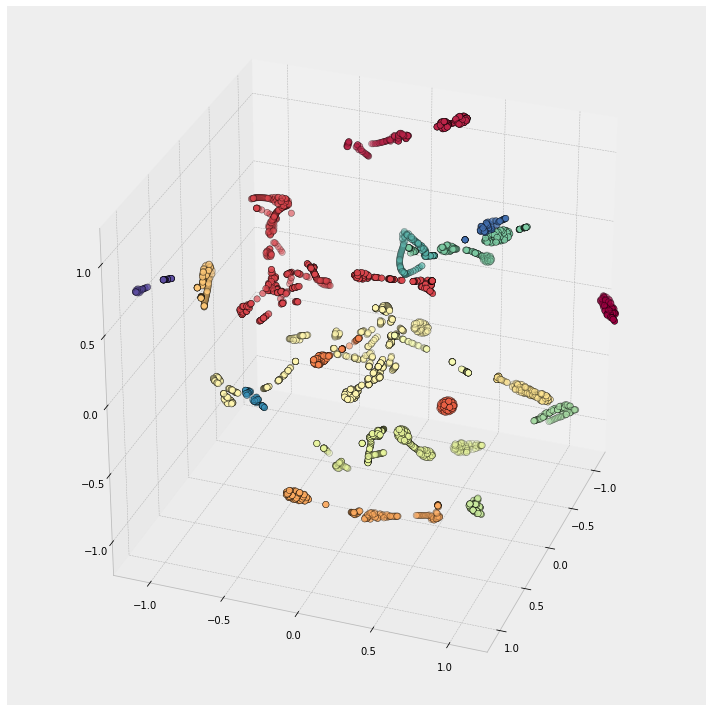

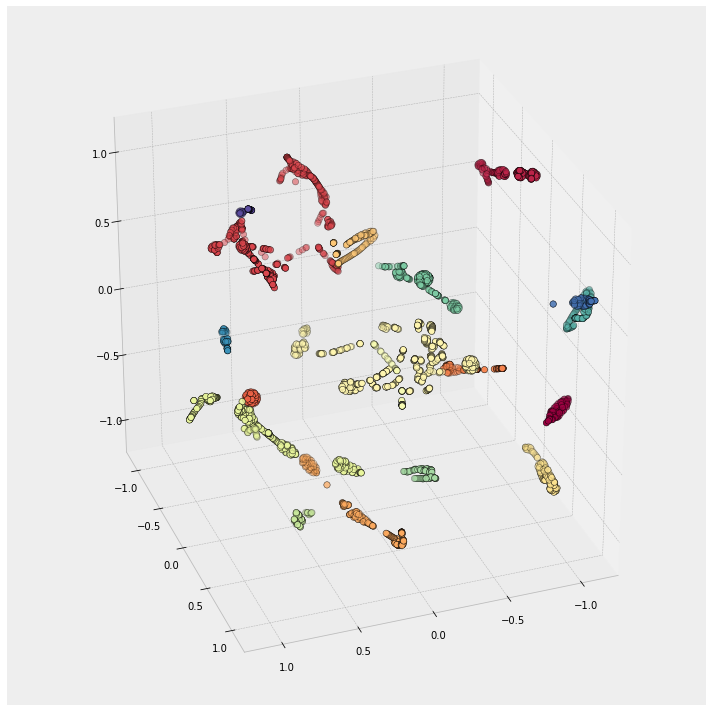

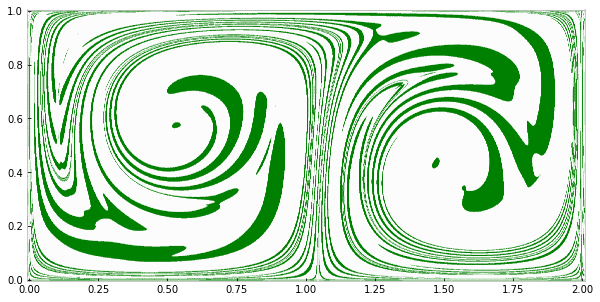

In [122]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
# X_ = scaler.fit_transform(nearest_nbs2)
X_ = scaler.fit_transform(X_tsne)
eig_scales = eigvals_mean[:,0,0]/eigvals_mean[:,0,0].max()#scaler.fit_transform(eigvals_mean.reshape(eigvals_mean.shape[0], 1))
# X_ = nearest_nbs
# X_ = X


epsil0 = 1.
epsil = epsil0
_clust = 40
samps = 10
n_clusters_ = 0
while(n_clusters_ < _clust):
#     db = DBSCAN(eps=epsil, min_samples=samps, metric='precomputed').fit(X_)
    db = DBSCAN(eps=epsil, min_samples=samps, n_jobs=-1).fit(X_)#, sample_weight=10*eig_scales)
#     db.predict(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 30
    if epsil <= epsil0 / 4: 
        epsil = epsil0
        _clust -= 3
        if _clust < 3:
            print('couldnt find shit')
            break
        
import time as tid

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=40, edgecolor='k')

    xy = X_[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=30, edgecolor='k')
print('Estimated number of clusters: %d' % n_clusters_)
ax.set_xlim3d(-1.2, 1.2)
ax.set_ylim3d(-1.2, 1.2)
ax.set_zlim3d(-1.2, 1.2)
ax.view_init(30, 20)
plt.tight_layout()

plt.savefig(fig_out_path + '/tsneDB_neigh_clusters1' + fig_num +'.png')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=40, edgecolor='k')

    xy = X_[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=30, edgecolor='k')
print('Estimated number of clusters: %d' % n_clusters_)
ax.set_xlim3d(-1.2, 1.2)
ax.set_ylim3d(-1.2, 1.2)
ax.set_zlim3d(-1.2, 1.2)
ax.view_init(30, 70)
plt.tight_layout()

plt.savefig(fig_out_path + '/tsneDB_neigh_clusters2' + fig_num +'.png')

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)
print(_clust)


In [123]:
nearest_nbs_inv2.min()

0.06000414345352645

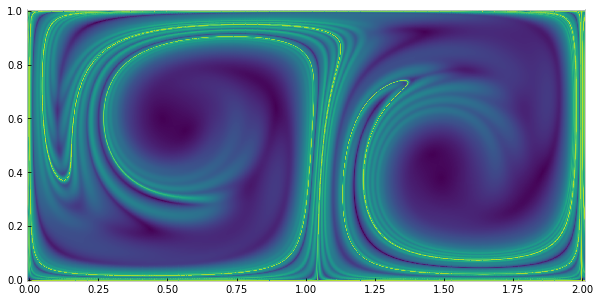

In [124]:
new_chosen = cherryPicker(
    chosen_LCS, eigvals_mean,
    nearest_nbs2, epsilon, mult=1.85)#7e-3
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/tsneDB_neigh' + fig_num +'.png')
ADVECTION_LINES = new_chosen


Estimated number of clusters: 18


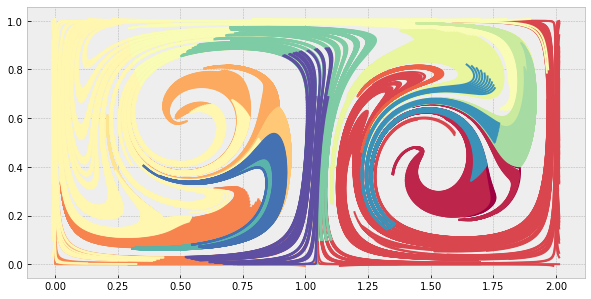

In [125]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/tsneDB_neigh_cols' + fig_num +'.png')

x_ shape:  (2912, 3)
nbs shape:  (2912, 2912)
Estimated number of clusters: 104
[]
0.9994097877142818


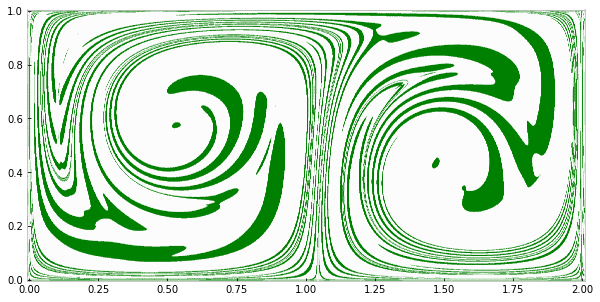

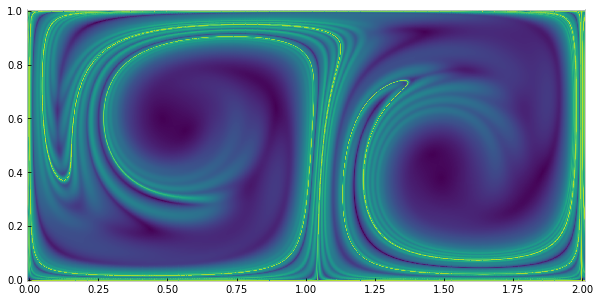

In [139]:
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import *
scaler = StandardScaler()
# X_ = scaler.fit_transform(nearest_nbs)
X_ = scaler.fit_transform(X_tsne)

# knn = kneighbors_graph(nearest_nbs2, n_neighbors=50, p=1, mode='distance', n_jobs=-1)

print('x_ shape: ', X_.shape)
print('nbs shape: ', nearest_nbs_inv2.shape)
# af = AffinityPropagation(damping=0.9, affinity='precomputed').fit(X_)
scaled_eigs = scaler.fit_transform(eigvals_mean[:,0,])
# af = AffinityPropagation(damping=0.6, preference=-1e2*np.exp(-scaled_eigs)).fit(X_)
af = AffinityPropagation(damping=0.6, preference=-1e2*np.exp(-scaled_eigs)).fit(X_)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


print('Estimated number of clusters: %d' % n_clusters_)


chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = 0#np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.85)#4e-4
maks = np.amax(flengths)
print(maks)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/tsneAFF_neigh' + fig_num +'.png')
ADVECTION_LINES = new_chosen

Estimated number of clusters: 104


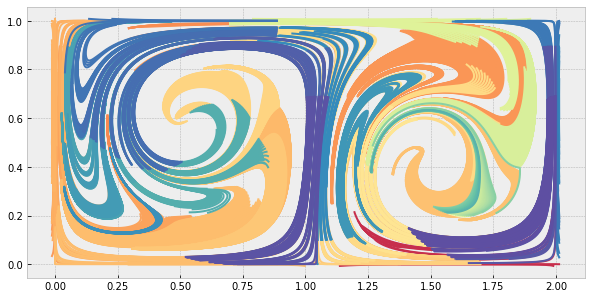

In [127]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/tsneAFF_neigh_cols' + fig_num +'.png')

Estimated number of clusters: 104


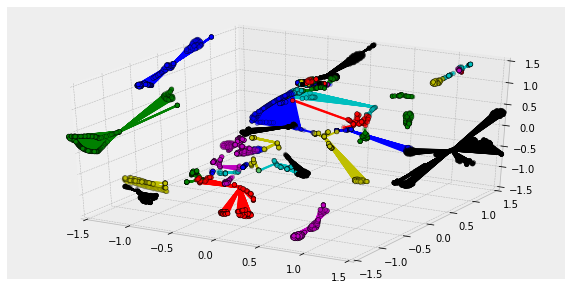

In [128]:
from itertools import cycle
fig = plt.figure(figsize=fig_s)
ax = fig.add_subplot(111, projection='3d')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_[cluster_centers_indices[k]]
    ax.scatter(X_[class_members, 0], X_[class_members, 1], X_[class_members, 2], c=col, edgecolor='k')
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], 'o', c=col, s=14, edgecolor='k')
    for x in X_[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], [cluster_center[2], x[2]], col)
ax.set_xlim3d(-1.5, 1.5)
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(-1.5, 1.5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/tsne_Aff_neigh__clusters' + fig_num +'.png')

/home/and/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 63 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


[]
0.9994097877142818


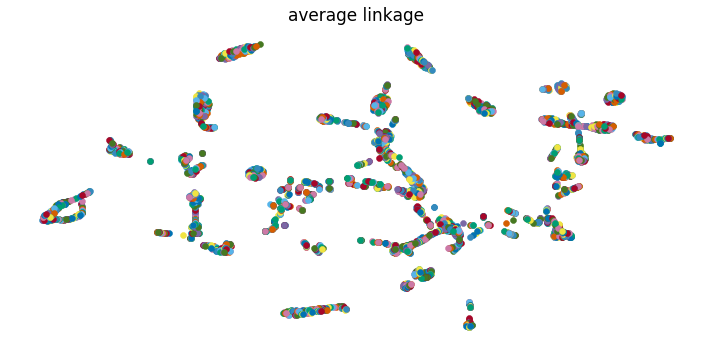

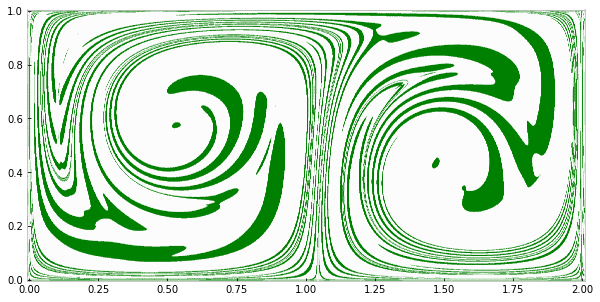

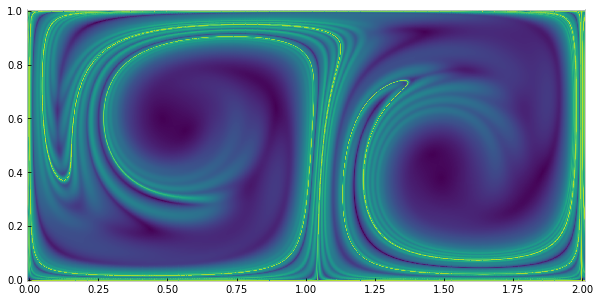

In [129]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=fig_s)
    for i in range(X_red.shape[0]):
        plt.scatter(X_red[i, 0], X_red[i, 1])#,
                 #color=plt.cm.spectral(labels[i] / 10.))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, datasets
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

scaler = StandardScaler()
# X_ = scaler.fit_transform(nearest_nbs)
X_ = scaler.fit_transform(X_tsne)
knn = kneighbors_graph(X_tsne, n_neighbors=10, mode='distance', include_self=False)
X_red = X_
linkage = 'average'
n_clusters_=AGG_CLUST
clustering = AgglomerativeClustering(affinity='l2',
    linkage=linkage, n_clusters=n_clusters_, connectivity=knn)

clustering.fit(X_red)

plot_clustering(X_red, X_, clustering.labels_, "%s linkage" % linkage)
labels = clustering.labels_
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))
#         print(i)

# plt.savefig('kpca_agg_' + fig_num +'.png')

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.9)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/tsneAGG_neigh' + fig_num +'.png')

Estimated number of clusters: 7


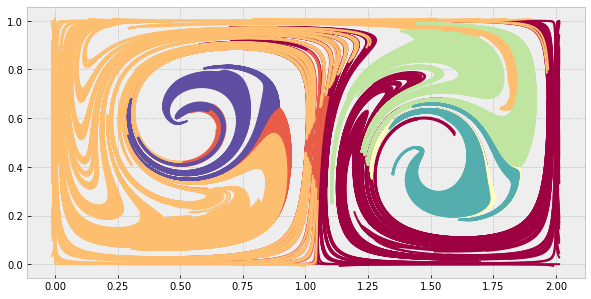

In [130]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/tsneAGG_neigh_cols' + fig_num +'.png')

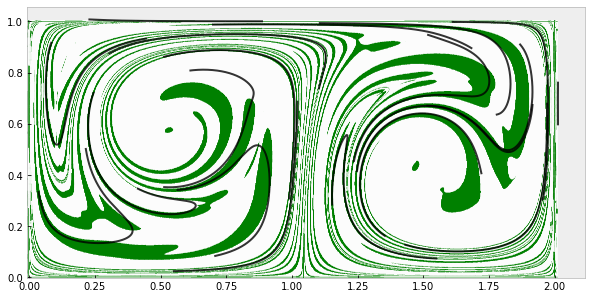

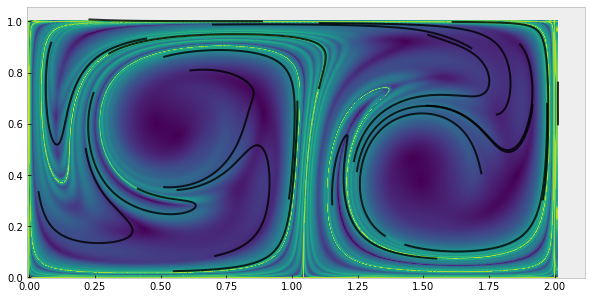

In [131]:
chosen_LCS = [x for x in range(len(fLCSs))]

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult = 2.0)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
#         print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/no_cluster2_' + fig_num + '.png')

maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): 
#         print(i)
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
# ADVECTION_LINES = new_chosen

# Cluster directly on sim matrix

In [132]:
X_.std()

1.0

Estimated number of clusters: 22
[]
3.4
3.4
20


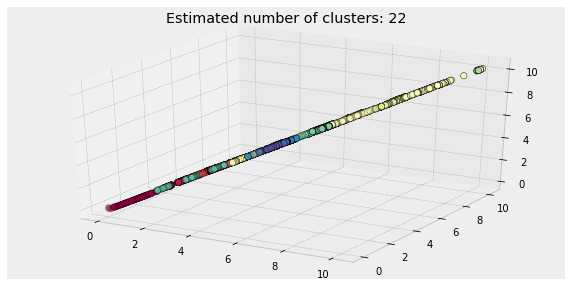

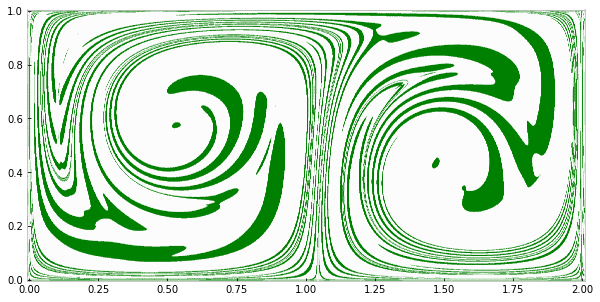

In [133]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
X_ = nearest_nbs2#scaler.fit_transform(nearest_nbs2)
#X_ = scaler.fit_transform(sims_)

# X_ = nearest_nbs
# X_ = X


epsil0 = 3.4
epsil = epsil0
_clust = 50
samps =1
n_clusters_ = 0
while(n_clusters_ < _clust):
#     db = DBSCAN(eps=epsil, min_samples=samps, metric='euclidean').fit(X, y)
    db = DBSCAN(eps=epsil, min_samples=samps, metric='precomputed', n_jobs=-1).fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
    epsil -= epsil0 / 40
    if epsil <= epsil0 / 3: 
        epsil = epsil0
        _clust -= 3
        if _clust < 2:
            print('couldnt find shit')
            break
        
import time as tid
# fig = plt.figure(figsize=fig_s)
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = X_[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=9)

#     xy = X_[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)

fig = plt.figure(figsize=fig_s)
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=40, edgecolor='k')

    xy = X_[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=tuple(col), s=30, edgecolor='k')
plt.title('Estimated number of clusters: %d' % n_clusters_)
# ax.set_xlim3d(-1.2, 1.2)
# ax.set_ylim3d(-1.2, 1.2)
# ax.set_zlim3d(-1.2, 1.2)

plt.savefig(fig_out_path + '/sims_DB_neigh_clusters' + fig_num +'.png')
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
print(epsil0)
print(epsil)
print(_clust)


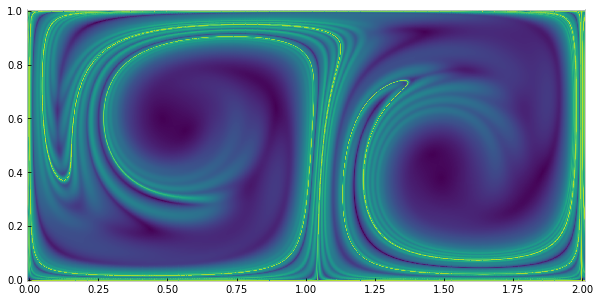

In [134]:
new_chosen = cherryPicker(
    chosen_LCS, eigvals_mean,
    nearest_nbs2, epsilon, mult=1.97)#7e-3
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/sims_DB_neigh' + fig_num +'.png')
ADVECTION_LINES = new_chosen

Estimated number of clusters: 22


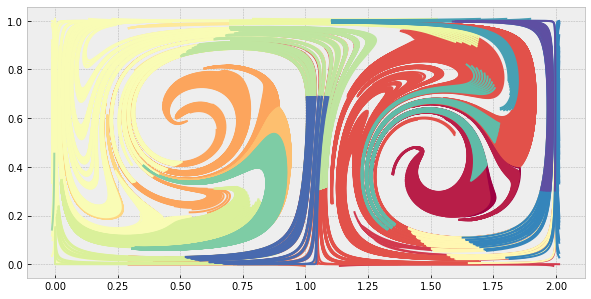

In [135]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/sims_DB_neigh_col' + fig_num +'.png')

In [ ]:
xys.shape

In [ ]:
from sklearn.cluster import AffinityPropagation
scaler = StandardScaler()
X_ = scaler.fit_transform(nearest_nbs2)
# X_ = scaler.fit_transform(sims_)
scaled_eigs = scaler.fit_transform(eigvals_mean[:,0,])
X_ = nearest_nbs2
# af = AffinityPropagation(damping=0.7, preference=-9.5e4*np.exp(scaled_eigs)).fit(X, y)
af = AffinityPropagation(damping=0.85, preference=-2.5e4*np.exp(-1*scaled_eigs*np.abs(eig_scales))).fit(X_) #
# af = AffinityPropagation(damping=0.7, preference=-4.5e3*nearest_nbs2).fit(X_)
# af = AffinityPropagation(damping=0.75, preference=-2.5e3 * eigvals_mean[:,0,0]/eigvals_mean[:,0,0].mean()).fit(X_)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


print('Estimated number of clusters: %d' % n_clusters_)


chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.10): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
        
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=2.3)#4e-4
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/sims_AFF_neigh' + fig_num +'.png')
ADVECTION_LINES = new_chosen

In [ ]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/sims_AFF_neigh_col' + fig_num +'.png')

In [ ]:
from itertools import cycle
fig = plt.figure(figsize=fig_s)
ax = fig.add_subplot(111, projection='3d')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_[cluster_centers_indices[k]]
    ax.scatter(X_[class_members, 0], X_[class_members, 1], X_[class_members, 2], c=col, edgecolor='k')
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], 'o', c=col, s=14, edgecolor='k')
    for x in X_[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], [cluster_center[2], x[2]], col)
# ax.set_xlim3d(-2.0, 2.0)
# ax.set_ylim3d(-2.0, 2.0)
# ax.set_zlim3d(-2.0, 2.0)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/sims_Aff__clusters' + fig_num +'.png')

In [ ]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=fig_s)
    for i in range(X_red.shape[0]):
        plt.scatter(X_red[i, 0], X_red[i, 1])#,
                 #color=plt.cm.spectral(labels[i] / 10.))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, datasets
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

scaler = StandardScaler()
# X_ = scaler.fit_transform(nearest_nbs)
X_ = scaler.fit_transform(nearest_nbs2)
knn = kneighbors_graph(nearest_nbs2, n_neighbors=5, mode='connectivity', include_self=False)
X_red = X_
linkage = 'complete'
n_clusters_=AGG_CLUST
clustering = AgglomerativeClustering(affinity='l2',
    linkage=linkage, n_clusters=n_clusters_, connectivity=knn)

clustering.fit(X_red)

plot_clustering(X_red, X_, clustering.labels_, "%s linkage" % linkage)
labels = clustering.labels_
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))
#         print(i)

# plt.savefig('kpca_agg_' + fig_num +'.png')

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs2, epsilon, mult=1.9)
maks = np.amax(flengths)
fig = plt.figure(figsize=fig_s)
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in set(new_chosen):
    if(flengths[i] > maks*0.1): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig(fig_out_path + '/simsAGG_neigh' + fig_num +'.png')

In [ ]:
fig = plt.figure(figsize=fig_s)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = xys[:,class_member_mask & core_samples_mask]
    xym = xys[:,class_member_mask & ~core_samples_mask]
    for i in range(xy.shape[1]):
        plt.plot(xy[0, i,:], xy[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=9)
    for i in range(xym.shape[1]):
    
        plt.plot(xym[0, i,:], xym[1, i,:], '-', c=tuple(col),
                 markeredgecolor='k', markersize=5)
print('Estimated number of clusters: %d' % n_clusters_)
plt.savefig(fig_out_path + '/simsAGG_neigh_cols' + fig_num +'.png')

# LCS advection
### moved to another notebook

Save the chosen lines to a file for later plotting.
(Bit simpler for plotting attracting and repelling lines at the same time)

In [ ]:
lines_ = np.zeros((len(ADVECTION_LINES), 2, X.shape[1]))

ite= 0
for i in set((ADVECTION_LINES)):
    lines_[ite,0,:] = X[i, :]
    lines_[ite,1,:] = y[i, :]
    ite+=1
import os
from os import path

advection_path = 'advection'
advect_file_ = 'AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{:d}'.format(max_notAB, np.abs(h), Nx, Ny, (n__))

if not os.path.exists(advection_path):
        os.mkdir(advection_path)

if h < 0.0:
    print('back')
    np.save(advection_path + '/backwards-' + advect_file_, lines_)
elif h > 0.0:
    print('forw')
    np.save(advection_path + '/forwards-' + advect_file_, lines_)

In [ ]:
h > 0

In [ ]:
xxyys.shape

In [ ]:
from concurrent import futures as fut
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def foo(kernels='rbf', ppl=100, n_comps=50, gamma=1/(2*nearest_nbs2.var()), angle=0.8):
    kpca0 = KernelPCA(kernel=kernels, fit_inverse_transform=True, n_components=n_comps, n_jobs=-1, gamma=gamma)
    # pca = PCA(n_components=30, whiten=True)
    # X__ = kpca0.fit_transform(X,y)
    # print(np.sum(pca.explained_variance_ratio_))
    X__ = kpca0.fit_transform(nearest_nbs2)
    X__ = StandardScaler().fit_transform(X__)
    tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=1500, perplexity=ppl, angle=angle)#, method='exact')
    X_tsne = tsne.fit_transform(X__)
    # for i in range(X_tsne.shape[1]):
    #     X_tsne[:,i] = X_tsne[:,i] / np.std(X_tsne[:,i])
    title =  'kernel-{}-ppl-{:d}-ncomps-{:d}-gamma-{:2.3f}'.format(kernels, ppl, n_comps, gamma)#   kernels + '-ppl' + str(ppl) + '-' + 'ncomps' + str(n_comps) + '-gamma' + str(gamma)
    return X_tsne, title
#     fig = plt.figure(figsize=fig_s)

#     ax = fig.add_subplot(111, projection='3d')

#     # plt.scatter(X_tsne[:,0], X_tsne[:,1])
#     ax.scatter(xs=X_tsne[:,0], ys=X_tsne[:,1], zs=X_tsne[:,2], zdir='z')

In [ ]:
lambs_n_lines = zip(eigvals_mean, fLCSs)
lambs_n_lines = sorted(lambs_n_lines, key=lambda x: x[0])
eigs_m, lines = zip(*lambs_n_lines)
# lambs_n_lines[0][0][0]
# lines_7[0]
fig = plt.figure(figsize=fig_s)
lines_7 = []
eigs = []
plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax)
for i in range(7):
    eigs.append(eigs_m[-(i+1)])
    lines_7.append(lines[-(i+1)])
    plt.plot(lines_7[i][0,:], lines_7[i][1,:], c='k', lw=1)
# lines_7[0][1,1]
plt.savefig(fig_out_path + '/strongest-lines' + fig_num +'.png')

In [ ]:
# futures = []

# perps = [40, 60, 80, 100] # removed 20
# n_comps = [25] # removed 50 75
# gammas = [1/10]#1 / (2*nearest_nbs2.var())]
# kernels = ['rbf', 'cosine', 'linear']
# with ProcessPoolExecutor(cpus) as executor:
#     for gs in set(gammas):
#         for k in set(kernels):
#             for c in set(n_comps):
#                 for i in range(len(perps)):
#             #         futures.append(executor.submit(foo,
#             #                                        perps[i], n_comps[0], gammas, angle=0.2))
#                     futures.append(executor.submit(foo,
#                                                    k, perps[i], n_comps=c, gamma=gs, angle=0.2))
#             #         futures.append(executor.submit(foo,
#             #                                        perps[i], n_comps[2], gammas, angle=0.2))
        
# ret = [] 
# titles = []
# count = 0
# for p in as_completed(futures):
# #     progressbar.value += 1
#     try:
#         ret_, title = p.result()
#         ret.append(ret_)
#         titles.append(title)
        
#     except IndexError:
#         pass

In [ ]:
# # ret[0,0]
# import os
# from os import path

# str_path = 'out'
# strain_path = str_path + '/tsne-n{:d}-h{:1.4f}-nx{:d}-ny{:d}'.format(n, h, Nx, Ny)

# if not os.path.exists(str_path):
#         os.mkdir(str_path)

# if not os.path.exists(strain_path):
#         os.mkdir(strain_path)

In [ ]:
# for i in range(len(ret)):
#     fig = plt.figure(figsize=fig_s)

#     ax = fig.add_subplot(111, projection='3d')

#     # plt.scatter(X_tsne[:,0], X_tsne[:,1])
#     ax.scatter(xs=ret[i][:,0], ys=ret[i][:,1], zs=ret[i][:,2], zdir='z')
#     ax.set_title(titles[i])
#     ax.set_xlim3d(-ret[i].std()*1.35, ret[i].std()*1.35)
#     ax.set_ylim3d(-ret[i].std()*1.35, ret[i].std()*1.35)
#     ax.set_zlim3d(-ret[i].std()*1.35, ret[i].std()*1.35)
#     plt.savefig(strain_path + '/' + titles[i] + '.png')
# #     plt.clf()
    

In [ ]:
# ret.min(), ret.max(), ret.var(), ret.std(), ret.mean()

In [ ]:
# ret.min(), ret.max(), ret.var(), ret.std(), ret.mean()